
## Data Analysis
1. Genres vs Avg-rating
    1. tmdb
    2. imdb
    3. rt
2. Genres vs box 
    1. tmdb
    2. rt_movie    

### Import libraries

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Load Data

In [2]:
!ls ./data

bom.movie_gross.csv.gz       imdb.title.ratings.csv.gz
imdb.name.basics.csv.gz      rt.movie_info.tsv.gz
imdb.title.akas.csv.gz       rt.reviews.tsv.gz
imdb.title.basics.csv.gz     tmdb.movies.csv.gz
imdb.title.crew.csv.gz       tn.movie_budgets.csv.gz
imdb.title.principals.csv.gz


In [4]:
#load datasets
bom = pd.read_csv('./data/bom.movie_gross.csv.gz')
imdb_name_basics = pd.read_csv('./data/imdb.name.basics.csv.gz')
imdb_tl_akas = pd.read_csv('./data/imdb.title.akas.csv.gz')
imdb_tl_basics = pd.read_csv('./data/imdb.title.basics.csv.gz')
imdb_tl_crew = pd.read_csv('./data/imdb.title.crew.csv.gz')
imdb_tl_principals = pd.read_csv('./data/imdb.title.principals.csv.gz')
imdb_tl_ratings = pd.read_csv('./data/imdb.title.ratings.csv.gz')
rt_movie = pd.read_csv('./data/rt.movie_info.tsv.gz', sep = '\t')
rt_reviews=pd.read_csv('./data/rt.reviews.tsv.gz', sep = '\t',  encoding='mac_roman')

In [31]:
tmdb_movies = pd.read_csv('./data/tmdb.movies.csv.gz')
tmdb_budgets = pd.read_csv('./data/tn.movie_budgets.csv.gz')

### Slice tmdb: keep movies in 2010-2019

In [32]:
# tmdb_movies

#'release_date'(2010-11-19): covert to datetime object
tmdb_movies['date'] = pd.to_datetime(tmdb_movies['release_date'])
# add year & month to tmdb_movies
tmdb_movies['year'] = tmdb_movies['date'].dt.year
tmdb_movies['month']= tmdb_movies['date'].dt.month

In [33]:
# tmdb_budgets

# 'release_date'(Dec 18, 2009): covert to datetime object
tmdb_budgets['date'] = pd.to_datetime(tmdb_budgets['release_date'])
# add year & month to tmdb_budgets
tmdb_budgets['year'] = tmdb_budgets['date'].dt.year
tmdb_budgets['month'] = tmdb_budgets['date'].dt.month

- slicing (2010-2019) 

In [34]:
# slice tmdb_movies (year 2010-2019)
mask = (tmdb_movies['year']<=2019) & (tmdb_movies['year']>=2010)
tmdb_movies = tmdb_movies.loc[mask].copy()

# slicing tmdb_budgets (year 2010-2019)
mask = (tmdb_budgets['year']<=2019) & (tmdb_budgets['year']>=2010)
tmdb_budgets = tmdb_budgets.loc[mask].copy()

### Genres - "Avg-rating"
1. tmdb
2. imdb
3. rt

#### tmdb.movies - (Genres - Avg_rating) 
- tmdb.movies

- parse genre_ids 

```
    orginal form:  
        movie 1, genre_ids '[12, 14, 10751]'
    target form: 
        movie 1, genre_id 12
        movie 1, genre_id 14
        movie 1, genre_id 10751
```        

In [36]:
import string
def parse_str(s):
    ''' convert s to a list of numbers
        example: 
        input: s = '[12, 14, 10751]'
        output: ['12', '14', '10751']   
    '''
    # strip all punctuation from a string 
    s = s.translate(str.maketrans('', '', string.punctuation))
    # string to list 
        # alternative: s_list = [int(n) for n in s.split()]
    return s.split()

In [37]:
# covert genre_ids '[12, 14, 10751]' to  list of int ['12', '14', '10751']
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(parse_str)

- melt based on a col [Ref-mikulskibartosz](https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/)

In [41]:
# df "tmdb_movies_genre"  =  a slice of original df "tmdb_movies"
cols = ['genre_ids','original_title','title', 'vote_average', 'vote_count','popularity','date', 'year', 'month','original_language']
tmdb_movies_genre = tmdb_movies[cols].copy() # a slice copy of tmdb_movies

In [42]:
# melt tmdb_movies_genre based on ['genre_ids']
id_vars = ['original_title','title', 'vote_average', 'vote_count','popularity','date', 'year', 'month','original_language']
tmdb_movies_genre = tmdb_movies_genre['genre_ids'].apply(pd.Series)\
                    .merge(tmdb_movies_genre, left_index = True, right_index = True)\
                    .drop(["genre_ids"], axis = 1)\
                    .melt(id_vars = id_vars, value_name = "genre")

In [45]:
# drop col 'variable'
tmdb_movies_genre.drop(columns=['variable'], inplace = True)  

In [46]:
# drop rows with genre NaN 
tmdb_movies_genre.dropna(subset = ['genre'], inplace = True)

- Check target result

In [49]:
# check and compare with movie '"BLESSED"'
mask = tmdb_movies['title'] =='"BLESSED"'
tmdb_movies[mask]

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,date,year,month
26355,26355,"[99, 12]",564096,en,"""BLESSED""",0.6,2018-11-23,"""BLESSED""",7.0,1,2018-11-23,2018,11


In [50]:
# Check 
tmdb_movies_genre.sort_values('title', axis=0).head(3)

,original_title,title,vote_average,vote_count,popularity,date,year,month,original_language,genre
26129,"""BLESSED""","""BLESSED""",7.0,1,0.6,2018-11-23,2018,11,en,99
52419,"""BLESSED""","""BLESSED""",7.0,1,0.6,2018-11-23,2018,11,en,12
33992,"""Legitimate Rape"" Pharmaceutical Ad","""Legitimate Rape"" Pharmaceutical Ad",2.3,2,0.6,2012-08-28,2012,8,en,80


#### mapping genres_id to genre 

In [51]:
tmdb_genres=[{'id': 28, 'name': 'Action'},
            {'id': 12, 'name': 'Adventure'},
            {'id': 16, 'name': 'Animation'},
            {'id': 35, 'name': 'Comedy'},
            {'id': 80, 'name': 'Crime'},
            {'id': 99, 'name': 'Documentary'},
            {'id': 18, 'name': 'Drama'},
            {'id': 10751, 'name': 'Family'},
            {'id': 14, 'name': 'Fantasy'},
            {'id': 36, 'name': 'History'},
            {'id': 27, 'name': 'Horror'},
            {'id': 10402, 'name': 'Music'},
            {'id': 9648, 'name': 'Mystery'},
            {'id': 10749, 'name': 'Romance'},
            {'id': 878, 'name': 'Science Fiction'},
            {'id': 10770, 'name': 'TV Movie'},
            {'id': 53, 'name': 'Thriller'},
            {'id': 10752, 'name': 'War'},
            {'id': 37, 'name': 'Western'}]

In [52]:
# mapping genres_id to genre

# 1. create a dict with {id_value1:genre1, id_value2:genre2} from tmdb_genres
genre_dict = {}
for pair in tmdb_genres:
    genre_dict[pair['id']] = pair['name']

# 'genre' col has dtype (O), convert to int 
tmdb_movies_genre['genre'] = tmdb_movies_genre['genre'].astype(int) 

# map genre_id to genre 
tmdb_movies_genre['genre'] = tmdb_movies_genre['genre'].map(genre_dict)  

In [53]:
# Check 
tmdb_movies_genre.sort_values('title', axis=0).head(3)

,original_title,title,vote_average,vote_count,popularity,date,year,month,original_language,genre
26129,"""BLESSED""","""BLESSED""",7.0,1,0.6,2018-11-23,2018,11,en,Documentary
52419,"""BLESSED""","""BLESSED""",7.0,1,0.6,2018-11-23,2018,11,en,Adventure
33992,"""Legitimate Rape"" Pharmaceutical Ad","""Legitimate Rape"" Pharmaceutical Ad",2.3,2,0.6,2012-08-28,2012,8,en,Crime


- so far the tmdb_movies_genre has the target format

### Vote_count by Genre (tmdb)

- Assumptions
    1. 1 movie data can contribute to multiple genre

- Visualize with raw data
    1. 2010-2018 (overall) : vote_count & vote_avg - genre
    2. 2010-2018 (each year, trend): vote_count & vote_avg - genre

- Beyond raw data 
    1. most popular movies, their percentage/contribution to genra data (80-20 rule of social phenomen)
    2. monthly dependency? 
    

- Null Value 
    - didn't check for now on purpose
    

#### groupby only 'genre' (tmdb)

- target table with cols: 

```
table fields/cols: 
    genre,
    movie_count,
    avg_vote_count, 
    vote_count_per_movie, 
    avg_vote_score, 
    vote_count_per_movie

fields details:
avg_vote_count: avg_vote_count per genre
vote_count_per_movie
    : avg_vote_count_per_movie_in_the_genre
    : = avg_vote_count/movie_count
```

- investigate the most popular genre
    - skewness? (say, 1 or 2 movies dominate the votes? )

#### Stats Table 1. tmdb_genre_vc  

In [79]:
# tmdb_genre_stats: dataframe, with genre as index
tmdb_genre_vc = tmdb_movies_genre.groupby('genre')['vote_count'].describe()
# reset index
#tmdb_genre_vc.reset_index(inplace = True)
# rename column names 
mapper = {'count':'movie_count',
         'mean':'vote_count_avg',
         'std':'vote_count_std',}
tmdb_genre_vc.rename(columns = mapper, inplace=True)

In [93]:
# Table
tmdb_genre_vc

,movie_count,vote_count_avg,vote_count_std,min,25%,50%,75%,max
genre,,,,,,,,
Action,2567.0,712.945462,2098.316280,1.0,4.00,24.0,175.00,22186.0
Adventure,1368.0,1168.625731,2853.210887,1.0,4.00,29.5,420.50,22186.0
Animation,1452.0,304.738292,1163.166918,1.0,2.00,9.0,64.25,12691.0
Comedy,5597.0,238.693050,948.216733,1.0,2.00,9.0,59.00,20175.0
Crime,1484.0,410.179245,1237.899755,1.0,4.00,19.5,176.00,13933.0
Documentary,4945.0,12.559151,40.727434,1.0,1.00,3.0,8.00,713.0
Drama,8207.0,242.684903,953.222677,1.0,3.00,11.0,67.00,18597.0
Family,1538.0,378.999350,1376.421407,1.0,3.00,12.0,61.75,12691.0
Fantasy,1113.0,765.440252,2160.438852,1.0,3.00,20.0,168.00,14587.0


#### Plot : Genre - MovieCount (bar plot)

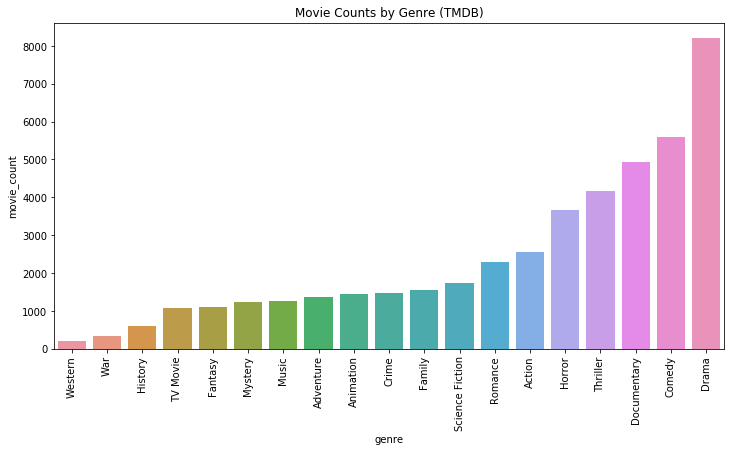

In [87]:
fig, ax = plt.subplots(figsize = (12,6))
data = pd.DataFrame(tmdb_genre_vc['movie_count'].sort_values()).reset_index()
sns.barplot(ax = ax, 
            x = data['genre'], 
            y = data['movie_count'])
plt.xticks(rotation='vertical')
plt.title('Movie Counts by Genre (TMDB)');

#### Plot : Genre - Vote_count 

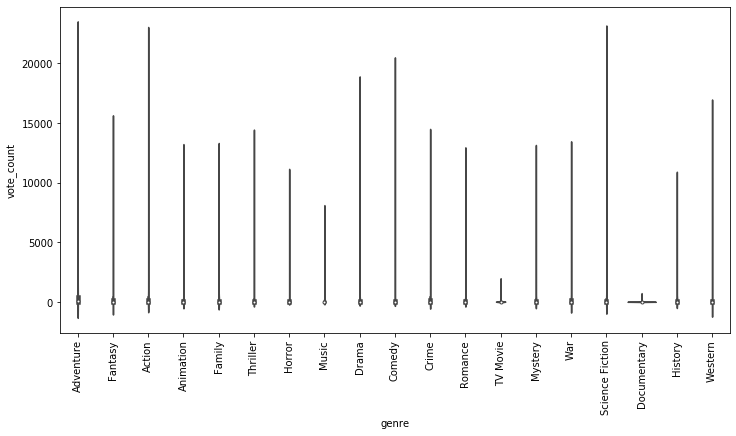

In [102]:
# violine plot for all groups 
fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(x="genre", y="vote_count", data=tmdb_movies_genre[['genre','vote_count']])
plt.xticks(rotation='vertical');

- Insights of Vote_count by Genre: 
    - very skewed: see std or compare 75% or 50% with max

#### grouby 'genre' &  'year' (tmdb)

- gente trend invesgation